<a href="https://colab.research.google.com/github/PierreSylvain/covid-chestxray-detector/blob/master/prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Chest X-ray Detector

Try to detect Covid-19 from X-rays, the datasets belongs to [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset) and [chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

There is 2 sources from X-rays because the first one have only X-rays with pathologies, and the second one contain  normal X-rays (an others pathologies, but we will use only the normal x-rays).

**Processing dataset**
 * Get Posteroanterior x-ray images. 
 * Keep only the fields 'finding', 'folder' and 'filename'
 * Change folder columns with the complete local path
 * Define the value to predict in setting "covid-19" and "covid-19, ARDS" field as true. The other will be set as false
 * Add new x-ray images to complete dataset
 * Split data into train, test, predict and copy them to a specific directory structure.

In [1]:
# Import necessary packages
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load dataset from github and kaggle

In [3]:
## Main dataset (https://github.com/ieee8023/covid-chestxray-dataset)
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
chestxray_images_folder = './covid-chestxray-dataset'

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 3676 (delta 28), reused 57 (delta 18), pack-reused 3599
Receiving objects: 100% (3676/3676), 715.78 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (1452/1452), done.
Checking out files: 100% (1151/1151), done.


In [46]:
# Setupo to retreive dataset from kaggle
# Full documentation at https://www.kaggle.com/general/74235
!pip install -q kaggle
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [49]:
# Alternate dataset to get more "normal" images
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
chestxray_normal_folder = './chest_xray/train/NORMAL'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-00

In [52]:
# Load data from covid-chestxray-dataset and display 5 first rows
raw_data = pd.read_csv(os.path.join(chestxray_images_folder,'metadata.csv'))
raw_data.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes
0,2,0.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
1,2,3.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
2,2,5.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
3,2,6.0,M,65.0,COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
4,4,0.0,F,52.0,COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN


## Prepare dataset
To have a omogenous dataset we will keep only from back to front (Posteroanterior) X-rays. Because we are trying to predict covid from X-ray images, we wil keep only the fields 'finding', 'folder' and 'filename'. We also need to set the correct path for the images.

In [53]:
#  Get only Posteroanterior X-rays 
chestxrays = raw_data[(raw_data['modality'] == 'X-ray') & (raw_data['view'] == 'PA')]

In [54]:
# keep 'finding', 'folder' and 'filename'
col_to_drop = ['patientid', 'offset', 'sex', 'age', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes','RT_PCR_positive']

chestxrays = chestxrays.drop(col_to_drop, axis=1)

In [55]:
# Set correct path according to local installation
chestxrays['filename'] = chestxrays.apply(lambda x : os.path.join(chestxray_images_folder,x.folder,x.filename),axis=1)
chestxrays.drop('folder', axis=1, inplace=True)

In [56]:
chestxrays.head()

,finding,filename
0,COVID-19,./covid-chestxray-dataset/images/auntminnie-a-...
1,COVID-19,./covid-chestxray-dataset/images/auntminnie-b-...
2,COVID-19,./covid-chestxray-dataset/images/auntminnie-c-...
3,COVID-19,./covid-chestxray-dataset/images/auntminnie-d-...
4,COVID-19,./covid-chestxray-dataset/images/nejmc2001573_...


## Define value to predict
When need to predict covid or not covid
change all 'finding' equal to 'COVID-19' to 1 and the others to 0 in a new col 'covid-19'


In [57]:
chestxrays["finding"].value_counts()

COVID-19                                           180
Pneumocystis                                        21
Pneumonia                                           13
todo                                                12
Streptococcus                                       12
COVID-19, ARDS                                      11
No Finding                                          10
Tuberculosis                                         9
SARS                                                 8
Klebsiella                                           7
Cryptogenic Organizing Pneumonia                     7
Lobar Pneumonia                                      5
MERS-CoV                                             4
Lipoid                                               4
Mycoplasma Bacterial Pneumonia                       4
Varicella                                            4
Legionella                                           4
Nocardia                                             4
Multilobar

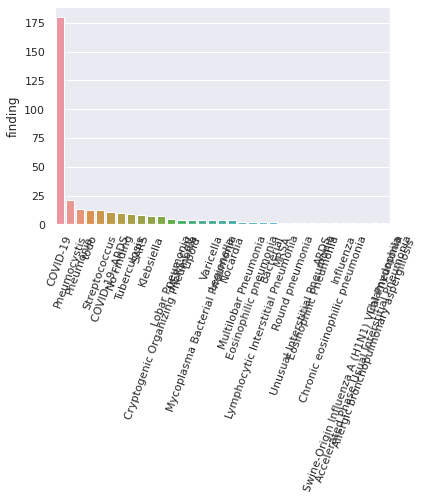

In [58]:
sns.barplot(x=chestxrays["finding"].value_counts().index, y=chestxrays["finding"].value_counts())
plt.xticks(rotation=70)
plt.show()

In [59]:
# add new column 'covid-19' and drop 'finding'
# set 1 for COVID-19 and COVID-19, ARDS and 0 for others values 
chestxrays['covid-19'] = chestxrays['finding'].map(lambda x:1 if (x == 'COVID-19' or x == 'COVID-19, ARDS') else 0)
chestxrays = chestxrays.drop(['finding'], axis=1)

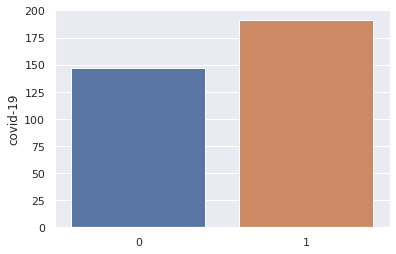

In [60]:
sns.barplot(x=chestxrays["covid-19"].value_counts().index, y=chestxrays["covid-19"].value_counts())
plt.show()

In [61]:
chestxrays["covid-19"].value_counts()

1    191
0    147
Name: covid-19, dtype: int64

In [62]:
chestxrays.head()

,filename,covid-19
0,./covid-chestxray-dataset/images/auntminnie-a-...,1
1,./covid-chestxray-dataset/images/auntminnie-b-...,1
2,./covid-chestxray-dataset/images/auntminnie-c-...,1
3,./covid-chestxray-dataset/images/auntminnie-d-...,1
4,./covid-chestxray-dataset/images/nejmc2001573_...,1


In [63]:
def display_random_images(df, nb_images):
    """Display x random images from dataset
    """
    random_index = [np.random.choice(df.index) for i in range(nb_images)]        
    plt.figure(figsize=(20,10))
    for i in range(nb_images):        
        image = df.iloc[i]['filename']     
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image)
        plt.imshow(img, cmap='gray')
        plt.axis('off')    
    plt.tight_layout()  

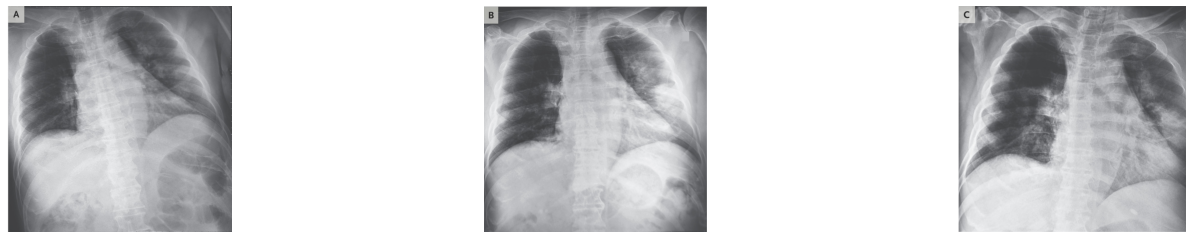

In [64]:
display_random_images(chestxrays, 3)

## Add new dataset
Add more non-covid chest X-rays from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia in directory train/NORMAL

In [65]:
nb_images_to_add = chestxrays["covid-19"].value_counts()[1] - chestxrays["covid-19"].value_counts()[0]
print(f"Number of normal images to add {nb_images_to_add}")

Number of normal images to add 44


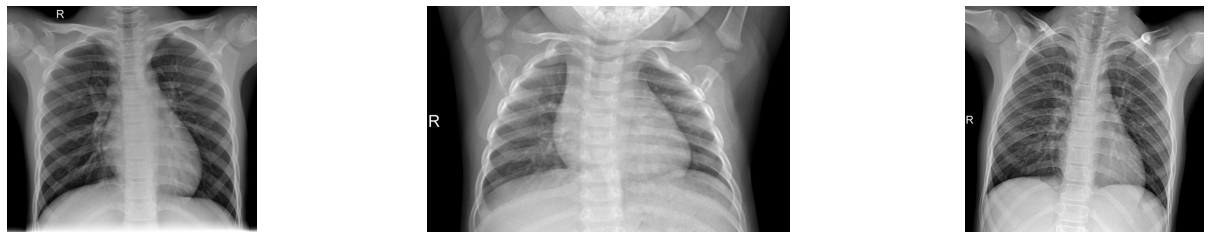

In [67]:
images = []
files = os.listdir(chestxray_normal_folder)
for name in files:
    images.append(name)
    
# Select randomly X images and add to new dataset
random_images = [np.random.choice(images) for i in range(nb_images_to_add)]    
column_names = ["filename","covid-19"]
chests = pd.DataFrame(columns = column_names)

for image in random_images:
    new_row = pd.Series(data={'filename': os.path.join(chestxray_normal_folder,image), 'covid-19':0})
    chests = chests.append(new_row, ignore_index=True)

    
display_random_images(chests, 3)

## Organize data

In [68]:
# Merge thge datasets
chestxrays = pd.concat([chestxrays, chests])

In [69]:
chestxrays["covid-19"].value_counts()

1    191
0    191
Name: covid-19, dtype: int64

In [70]:
# Save as CSV
chestxrays.to_csv('./chestxrays.csv', index=False)

In [71]:
import shutil
import os.path 

In [72]:
def cleanDestination(destination):
    """Delete folder and subdirectories
    """
    try:
        shutil.rmtree(destination)
    except OSError:
        pass

In [73]:
def copyData(source, destination, new_filename=""):
    """
    Copy file to specified directory. Create destination directory if needed
    """
    try :
        os.makedirs(destination)
    except OSError:
        pass
    
    if new_filename:
        destination = os.path.join(destination,new_filename)   
    else:
        destination = os.path.join(destination,os.path.basename(source))   
        
    shutil.copyfile(source, destination)       
        

In [74]:
# Split data into train, test and predict directories
train_dir = 'data/train/'
test_dir  = 'data/test/'
pred_dir  = 'data/predict/'

cleanDestination(train_dir)
cleanDestination(test_dir) 
cleanDestination(pred_dir) 
    
train_test,predict = train_test_split(chestxrays, test_size=0.1, random_state=42)
train, test = train_test_split(train_test, test_size=0.2, random_state=42)

# Predict data
for index, row in predict.iterrows():
    filename = str(row['covid-19']) + '-' + os.path.basename(row['filename'])
    copyData(row['filename'], pred_dir, filename )
    
# Train data
for index, row in train.iterrows():
    destination = train_dir + '0_normal'
    if row['covid-19'] == 1:
        destination = train_dir +  '1_covid'
    copyData(row['filename'], destination)

# Test data
for index, row in test.iterrows():
    destination = test_dir + '0_normal'
    if row['covid-19'] == 1:
        destination = test_dir + '1_covid'
    copyData(row['filename'], destination)


In [79]:
from google.colab import files
!zip -r data.zip data
files.download( "data.zip" ) 

  adding: data/ (stored 0%)
  adding: data/predict/ (stored 0%)
  adding: data/predict/1-2cd63b76.jpg (deflated 0%)
  adding: data/predict/0-IM-0475-0001.jpeg (deflated 1%)
  adding: data/predict/0-SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg (deflated 0%)
  adding: data/predict/0-b2f42e0cdfcbe32f189eb467b05e24_jumbo.jpg (deflated 1%)
  adding: data/predict/1-1052b0fe.jpg (deflated 0%)
  adding: data/predict/1-1-s2.0-S2387020620301959-gr4_lrg-b.png (deflated 0%)
  adding: data/predict/1-auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg (deflated 3%)
  adding: data/predict/0-X-ray_of_cyst_in_pneumocystis_pneumonia_1.jpg (deflated 0%)
  adding: data/predict/0-NORMAL2-IM-0959-0001.jpeg (deflated 1%)
  adding: data/predict/1-gr1_lrg-b.jpg (deflated 4%)
  adding: data/predict/0-000001-1.jpg (deflated 1%)
  adding: data/predict/1-1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4a.png (deflated 2%)
  adding: data/predict/1-thnov10p5641g006-c.png (deflated 1%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>